# Wine - 베스트 모델 찾기, 와인 다진분류

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
wine = pd.read_csv("dataset/wine.csv",header=None)
wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


### 데이터 전처리 

In [3]:
# 와인 등급별 데이터 개수 확인 - 개수가 적은 3번과 9번 제외 후 진행하기로 결정
wine.iloc[:,11].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: 11, dtype: int64

In [4]:
# 3번과 9번 제거
wine.drop(wine[np.logical_or(wine[11]==3 , wine[11]==9)].index,inplace=True)

In [5]:
# 잘 제거되었는지 확인
wine.iloc[:,11].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
Name: 11, dtype: int64

In [6]:
# 라벨링
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
wine_class = encoder.fit_transform(wine.iloc[:,11].values)

In [7]:
# 원핫인코딩
from tensorflow.keras.utils import to_categorical
y_onehot = to_categorical(wine_class)
y_onehot[:3]

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [8]:
# X값 정의
wine_X = wine.drop([11],axis=1)
wine_X

,0,1,2,3,4,5,6,7,8,9,10,12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,0


In [9]:
# 데이터 정규화 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(wine_X.values)

### 데이터셋 나누기 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, stratify=y_onehot, random_state=seed)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4846, 12), (1616, 12), (4846, 5), (1616, 5))

### 모델 정의 / 설정

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [25]:
model = Sequential()
model.add(Dense(56,input_dim=12,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 56)                728       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1710      
_________________________________________________________________
dense_10 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 80        
Total params: 2,983
Trainable params: 2,983
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
# 모델 저장
model_path = 'model/best_wine_grade2.h5'

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    model_path, monitor='val_loss', verbose=1, save_best_only=True
)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=20)  

### 모델 학습 및 저장 

In [29]:
history = model.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=200, batch_size=500, verbose=0, 
    callbacks=[checkpointer,early_stopping])


Epoch 00001: val_loss improved from inf to 1.56157, saving model to model\best_wine.h5

Epoch 00002: val_loss improved from 1.56157 to 1.50572, saving model to model\best_wine.h5

Epoch 00003: val_loss improved from 1.50572 to 1.44495, saving model to model\best_wine.h5

Epoch 00004: val_loss improved from 1.44495 to 1.38024, saving model to model\best_wine.h5

Epoch 00005: val_loss improved from 1.38024 to 1.31878, saving model to model\best_wine.h5

Epoch 00006: val_loss improved from 1.31878 to 1.27429, saving model to model\best_wine.h5

Epoch 00007: val_loss improved from 1.27429 to 1.24738, saving model to model\best_wine.h5

Epoch 00008: val_loss improved from 1.24738 to 1.22133, saving model to model\best_wine.h5

Epoch 00009: val_loss improved from 1.22133 to 1.19850, saving model to model\best_wine.h5

Epoch 00010: val_loss improved from 1.19850 to 1.17737, saving model to model\best_wine.h5

Epoch 00011: val_loss improved from 1.17737 to 1.16327, saving model to model\best_

### 평가는 베스트 모델로 해야 함.

In [30]:
from tensorflow.keras.models import load_model
best_model = load_model('model/best_wine_grade2.h5')

In [31]:
best_model.evaluate(X_test, y_test)

51/51 [==============================] - 0s 587us/step - loss: 1.0068 - accuracy: 0.5507


[1.006773591041565, 0.5507425665855408]

### 훈련과정 시각화 

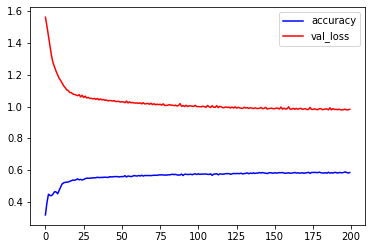

In [32]:
import matplotlib.pylab as plt
%matplotlib inline

y_acc = history.history['accuracy']
y_vloss = history.history['val_loss']

x_len = np.arange(len(y_acc))

plt.plot(x_len, y_acc, 'b-',markersize=5, label='accuracy')
plt.plot(x_len, y_vloss, 'r-',markersize=5, label='val_loss')
plt.legend()
plt.show()